In [ ]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import h5py
import copy
from scipy.stats import zscore
import cv2
%matplotlib inline

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import autocorr_mat, get_lagplot
from data_preprocessing.preprocessing import format_in_trials

In [ ]:
exp_name = "paul_20250914"
data_path = f"{paths['livingstone_lab']}/Data/Data-Formatted/{exp_name}_experiment.mat"
d = loadmat(data_path)

In [9]:
#print(d.keys())  # each of these is a different "dataset" (e.g. Trials, Stimuli)
trials = d["Trials"]
print("trials : ", trials.dtype.names)
stimuli = d["Stimuli"]
print("stimuli : ", stimuli.dtype.names)
# then index like a matlab struct trials[4]["success"]

trials :  ('start_time', 'stop_time', 'success', 'error_code', 'photodiode_flip_times', 'events_matched', 'event_words', 'event_times', 'eye_data_sample_interval', 'eye_data', 'fixation_point', 'user_vars', 'images', 'eye_data_clip_mask', 'fixation_positions', 'fixation_times', 'saccade_times')
stimuli :  ('trial_number', 'serial_number', 'start_time', 'stop_time', 'latency', 'position', 'size_px', 'filename', 'subdir')


In [10]:
rasters_path = f"{paths['livingstone_lab']}/Data/Data-Formatted/{exp_name}-rasters.h5"
with h5py.File(rasters_path, "r") as f:
    print(list(f.keys()))
    print(f["rasters"].shape)  # (1262371, 64)
    #print(f["unit_names"][:])  # convert with array.astype(int)
    rasters = f["rasters"][:]

['file_versions', 'rasters', 'unit_names']
(1262371, 64)


In [11]:
s = np.concatenate(stimuli["filename"])
file_list = [str(x[0]) for x in s]

In [12]:
len_window_firing_rate = 1000/30
neural, gaze = format_in_trials(file_list, len_window_firing_rate, rasters, trials, stimuli)

15:14:02 - Warning! anna2_to_marge_10s_rev.mp4 has different time-points across trials [301, 302]
15:14:02 - Warning! rubin2a_10s.mp4 has different time-points across trials [302, 301]
15:14:02 - Warning! anna2_to_marge_10s.mp4 has different time-points across trials [301, 301, 302]
15:14:02 - Warning! rubin2a_rev.mp4 has different time-points across trials [301, 301, 301, 300, 300]
15:14:02 - Warning! rubin2_to_girl1_10s.mp4 has different time-points across trials [301, 302]
15:14:02 - Warning! anna2_to_marge_10s_rev.mp4 has different time-points across trials [301, 302]
15:14:02 - Warning! rubin2a_10s.mp4 has different time-points across trials [302, 301]
15:14:02 - Warning! anna2_to_marge_10s.mp4 has different time-points across trials [301, 301, 302]
15:14:02 - Warning! rubin2a_rev.mp4 has different time-points across trials [301, 301, 301, 300, 300]
15:14:02 - Warning! rubin2_to_girl1_10s.mp4 has different time-points across trials [301, 302]


In [36]:
import pickle
with open("/Users/tizianocausin/Desktop/neural_dict.pkl", "wb") as f:
    pickle.dump(neural, f)

np.savez("/Users/tizianocausin/Desktop/neural_dict.npz", **neural)

In [39]:
loaded = np.load("/Users/tizianocausin/Desktop/neural_dict.npz")
print(type(loaded), loaded.files)          # list of keys
print(loaded["anna2_to_marge_10s_rev.mp4"].shape)           # access each array

<class 'numpy.lib.npyio.NpzFile'> ['anna2_to_marge_10s_rev.mp4', 'anna1_10s.mp4', 'rubin2_to_girl1_10s_rev.mp4', 'rubin2a_10s.mp4', 'rubin_to_venus_10s.mp4', 'anna2_to_marge_10s.mp4', 'anna1_to_guy1_10s_rev.mp4', 'anna1_to_guy1_10s.mp4', 'rubin2a_rev.mp4', 'anna1_10s_rev.mp4', 'rubin2_to_girl1_10s.mp4', 'rubin_to_venus_10s_rev.mp4', 'anna1_to_roscoe_10s.mp4']
(64, 301, 2)


In [ ]:
with open("/Users/tizianocausin/Desktop/neural_dict.pkl", "rb") as f:
    loaded_data = pickle.load(f)


dict_keys(['anna2_to_marge_10s_rev.mp4', 'anna1_10s.mp4', 'rubin2_to_girl1_10s_rev.mp4', 'rubin2a_10s.mp4', 'rubin_to_venus_10s.mp4', 'anna2_to_marge_10s.mp4', 'anna1_to_guy1_10s_rev.mp4', 'anna1_to_guy1_10s.mp4', 'rubin2a_rev.mp4', 'anna1_10s_rev.mp4', 'rubin2_to_girl1_10s.mp4', 'rubin_to_venus_10s_rev.mp4', 'anna1_to_roscoe_10s.mp4']) <class 'numpy.ndarray'>


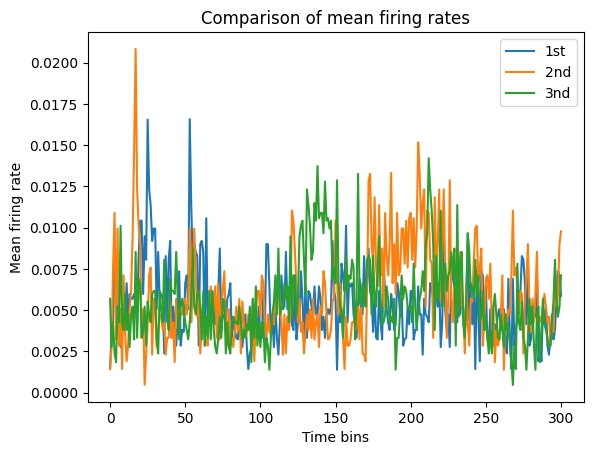

In [13]:
plt.plot(np.mean(neural["anna2_to_marge_10s.mp4"][:, :, 0], axis=0), label="1st")
plt.plot(np.mean(neural["anna2_to_marge_10s.mp4"][:, :, 1], axis=0), label="2nd")
plt.plot(np.mean(neural["anna2_to_marge_10s.mp4"][:, :, 2], axis=0), label="3nd")
plt.legend()
plt.xlabel("Time bins")
plt.ylabel("Mean firing rate")
plt.title("Comparison of mean firing rates")
plt.show()

Text(0, 0.5, 'Time bins')

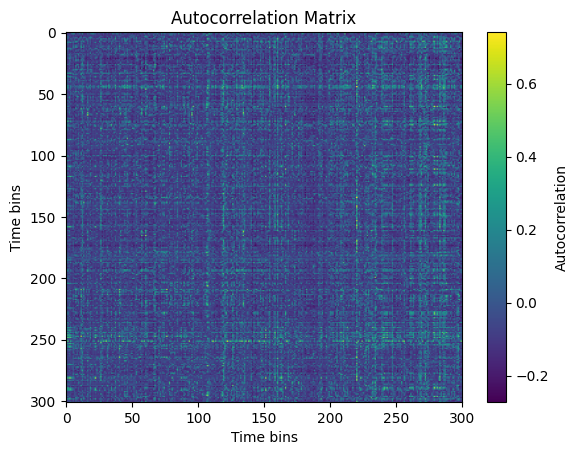

In [18]:
m = autocorr_mat(neural["anna2_to_marge_10s.mp4"][:, :, 0],neural["anna2_to_marge_10s_rev.mp4"][:, :, 0][::-1] )
plt.imshow(m, aspect='auto', cmap='viridis')
plt.colorbar(label='Autocorrelation')
plt.title("Autocorrelation Matrix")
plt.xlabel("Time bins")
plt.ylabel("Time bins")

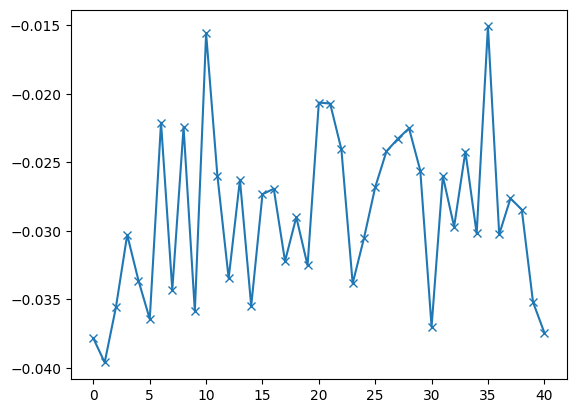

In [19]:
lagplot = get_lagplot(m)
plt.plot(lagplot, marker='x')

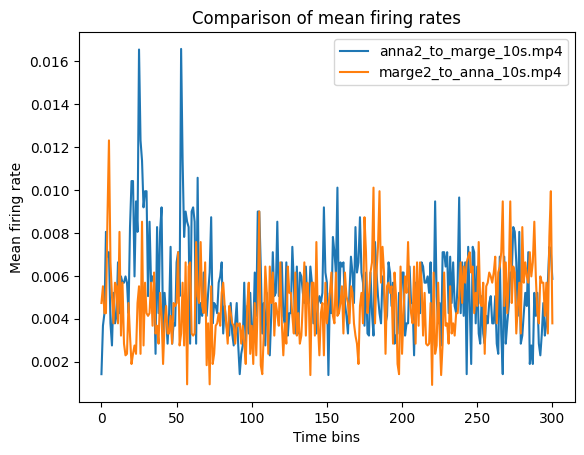

In [23]:
#fig, axes = plt.subplots(5, 3, figsize=(10, 6))
#plt.plot(anna2_to_marge_10s.mp4")
# plot one video on top of the other inverted
plt.plot(np.mean(neural["anna2_to_marge_10s.mp4"][:, :, 0], axis=0), label="anna2_to_marge_10s.mp4")
plt.plot(np.mean(neural["anna2_to_marge_10s_rev.mp4"][:, :, 0][::-1], axis=0), label="marge2_to_anna_10s.mp4")
plt.legend()
plt.xlabel("Time bins")
plt.ylabel("Mean firing rate")
plt.title("Comparison of mean firing rates")
plt.show()

In [26]:
import numpy as np
import sounddevice as sd

def firing_rate_to_noise(firing_rate, fs=44100, duration=0.5, play=True):
    """
    Generate 0.5 s of white noise whose amplitude scales with a firing rate.

    Parameters
    ----------
    firing_rate : float
        Input firing rate (arbitrary units, e.g. spikes/s). 
        The amplitude will be proportional to this value.
    fs : int
        Sampling rate (Hz).
    duration : float
        Duration of the sound in seconds (default: 0.5).
    play : bool
        If True, plays the sound. Otherwise returns the waveform.

    Returns
    -------
    sound : np.ndarray
        The generated noise waveform.
    """
    # Normalize firing rate to [0, 1] (you can tune this scaling)
    a = np.clip(firing_rate / 100.0, 0, 1)  # assume 100 Hz max for scaling

    # Generate white noise
    n_samples = int(fs * duration)
    noise = np.random.uniform(-1, 1, n_samples)

    # Modulate amplitude by firing rate
    sound = a * noise

    if play:
        sd.play(sound, samplerate=fs)
        sd.wait()
    return sound

In [34]:
a = np.random.randn(10, 15)
np.mean(a, axis=1).shape

(10,)

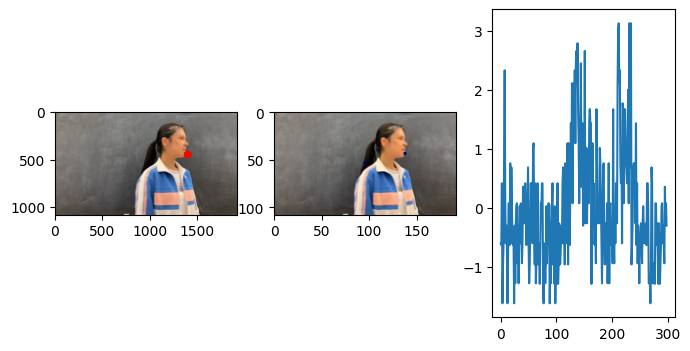

In [32]:
from IPython.display import clear_output

curr_file = "anna2_to_marge_10s.mp4"
video_file = f"/Volumes/LivingstoneLab/Stimuli/faceswap_4/{curr_file}"
ctrl_video_file = f"/Users/tizianocausin/figimages/temp/250914-depths{curr_file}.avi"
rep = 2
cap = cv2.VideoCapture(video_file)
ctrl_cap = cv2.VideoCapture(ctrl_video_file)
timestamps = []
g = copy.deepcopy(gaze[curr_file][:,:,rep])
n = copy.deepcopy(neural[curr_file][:40, :, rep])

n_z = zscore(n[:20, :], axis=0)
n_mean_z = zscore(np.mean(n[:20, :], axis=0))
for i in range(g.shape[1]):
    ret, frame = cap.read()
    ret, ctrl_frame = ctrl_cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ctrl_frame = cv2.cvtColor(ctrl_frame, cv2.COLOR_BGR2RGB)
   #frame = cv2.resize(frame, (192, 108))
    
    # fig = plt.imshow(frame)
    # plt.scatter(g[0, i], g[1, i], s = 50)
    # plt.pause(1)
    # plt.close(fig)
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[0].imshow(frame)
    ax[0].scatter(g[0, i], g[1, i], s=20, c='r')
    firing_rate_to_noise(n_mean_z[i], fs=44100, duration=0.05, play=True)
    ax[1].imshow(ctrl_frame)
    ax[2].plot(n_mean_z[:i])
    plt.show()
    plt.close(fig)
    clear_output(wait=True)
cap.release()